In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D,
    Multiply, Add, Activation, LayerNormalization, Dropout, Lambda, Concatenate, Reshape
)
from tensorflow.keras.layers import MultiHeadAttention
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

In [5]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [6]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [7]:
def load_dataset_group(group, base_path=''):
    filepath = base_path + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(base_path + group + '/y_'+group+'.txt')
    return X, y

In [8]:
def load_dataset(base_path=''):
    trainX, trainy = load_dataset_group('train', base_path)
    testX, testy = load_dataset_group('test', base_path)
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [9]:
BASE_PATH = '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/'

In [10]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(BASE_PATH)

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [11]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]
print(f"입력 형태: (타임스텝={n_timesteps}, 특성={n_features}), 출력 클래스={n_outputs}")

입력 형태: (타임스텝=128, 특성=9), 출력 클래스=6


In [12]:
def cbam_module(input_tensor, ratio=8):
    channel = int(input_tensor.shape[-1])

    avg_pool = GlobalAveragePooling1D()(input_tensor)
    max_pool = GlobalMaxPooling1D()(input_tensor)

    shared_dense_one = Dense(channel // ratio, activation='relu')
    shared_dense_two = Dense(channel, activation='sigmoid')

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_attention = Reshape((1, channel))(channel_attention)
    x = Multiply()([input_tensor, channel_attention])

    avg_pool_spatial = Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool_spatial = Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv1D(1, 7, padding='same', activation='sigmoid')(concat)

    refined_feature = Multiply()([x, spatial_attention])
    return refined_feature

In [13]:
def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout=0.1):
    embed_dim = int(inputs.shape[-1])
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization()(out1)

    ffn = Dense(ff_dim, activation='relu')(out1)
    ffn = Dense(embed_dim)(ffn)
    out2 = Add()([out1, ffn])
    out2 = LayerNormalization()(out2)
    return out2

In [14]:
inputs = Input(shape=(n_timesteps, n_features))
x = cbam_module(inputs)
x = transformer_encoder(x, num_heads=4, ff_dim=64)
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)  # GlobalAveragePooling1D 대체
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

cbam_transformer_model = Model(inputs, outputs)
cbam_transformer_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cbam_transformer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 9)         │          0 │ input_layer_3[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 9)         │          0 │ input_layer_3[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         10 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 9)         │         18 │ dense_10[0][0],   │
│                     │                   │            │ dense_10[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 9)         │          0 │ dense_11[0][0],   │
│                     │                   │            │ dense_11[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 9)         │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 9)      │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 128, 9)    │          0 │ input_layer_3[0]… │
│ (Multiply)          │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128, 1)    │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 128, 1)    │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 2)    │          0 │ lambda_3[0][0],   │
│ (Concatenate)       │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 1)    │         15 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 128, 9)    │          0 │ multiply_2[0][0], │
│ (Multiply)          │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 9)    │      1,413 │ multiply_3[0][0], │
│ (MultiHeadAttentio… │                   │            │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 9)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 128, 9)    │          0 │ multiply_3[0][0], │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 9)    │         18 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,915 (42.64 KB)

 Trainable params: 10,915 (42.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model_history = cbam_transformer_model.fit(
    X_train,
    y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - accuracy: 0.6025 - loss: 1.0298 - val_accuracy: 0.8668 - val_loss: 0.3901
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.8870 - loss: 0.3205 - val_accuracy: 0.8987 - val_loss: 0.2335
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9220 - loss: 0.2086 - val_accuracy: 0.9218 - val_loss: 0.1886
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9279 - loss: 0.1749 - val_accuracy: 0.9409 - val_loss: 0.1596
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9463 - loss: 0.1392 - val_accuracy: 0.9279 - val_loss: 0.1556
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9487 - loss: 0.1307 - val_accuracy: 0.9293 - val_loss: 0.1489
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.9505 - loss: 0.1229 - val_accuracy: 0.9470 - val_loss: 0.1274
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9536 - loss: 0.1165 - 

In [16]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

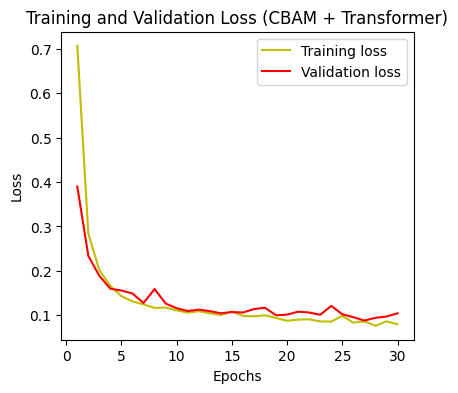

In [17]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss (CBAM + Transformer)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

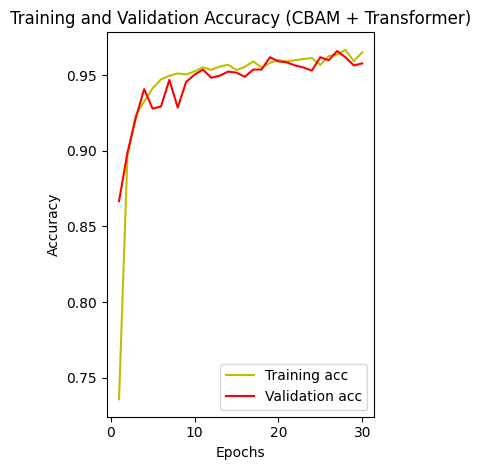

In [18]:
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy (CBAM + Transformer)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step

=== Confusion Matrix ===
[[428  49  14   3   2   0]
 [ 39 416  14   2   0   0]
 [ 44  12 364   0   0   0]
 [  0  23   0 333 135   0]
 [  0   0   0  40 492   0]
 [  0  27   0   0   0 510]]

Accuracy: 0.8629114353579912

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       496
           1       0.79      0.88      0.83       471
           2       0.93      0.87      0.90       420
           3       0.88      0.68      0.77       491
           4       0.78      0.92      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.86      2947
   macro avg       0.87      0.86      0.86      2947
weighted avg       0.87      0.86      0.86      2947



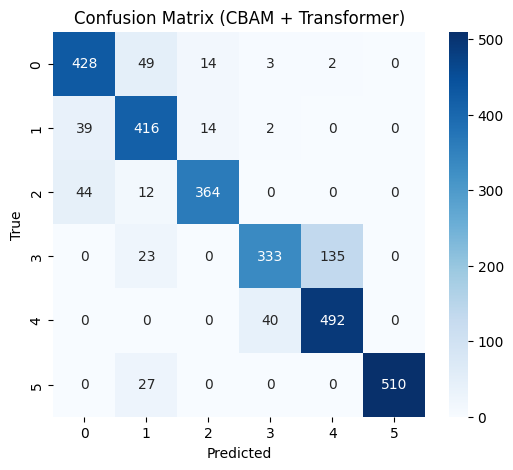

In [19]:
pred = cbam_transformer_model.predict(testX)
pred_classes = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred_classes)

print("\n=== Confusion Matrix ===")
print(cm)
print("\nAccuracy:", accuracy_score(testy, pred_classes))
print("\n=== Classification Report ===")
print(classification_report(testy, pred_classes))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (CBAM + Transformer)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()